In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *
from lifelines import KaplanMeierFitter, CoxPHFitter
import math

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


In [2]:
def missing_impute(y, missing_to_num=-1):
    y_outcome = copy.deepcopy(y)
    event_indicator = (y_outcome>0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_outcome[mask] = missing_to_num
    return y_outcome

def long_to_surv(y):
    num_individuals, num_time_points = y.shape
    times = []
    events = []

    for i in range(num_individuals):
        individual = y[i].tolist()
        try:
            # Find the index of the first event (1)
            event_time = individual.index(1) + 1  # +1 if time starts at 1
            event = 1
        except ValueError:
            # If no event occurred, censor at the last time point
            event_time = num_time_points
            event = 0
        
        times.append(event_time)
        events.append(event)

    df = pd.DataFrame({
        'time': times,
        'event': events,
    })
    return df
def plot_survival_time_distribution(df_ground_truth, df_estimate, x_value):
    """
    Plots the distribution of survival times for Ground Truth and FR Estimate.

    Parameters:
    - df_ground_truth: DataFrame containing 'time' for Ground Truth.
    - df_estimate: DataFrame containing 'time' for FR Estimate.
    - x_value: The value of x (0 or 1) being plotted.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot Ground Truth Distribution
    sns.kdeplot(data=df_ground_truth, x='time', fill=True, color='blue', label='Ground Truth', alpha=0.5)
    
    # Plot FR Estimate Distribution
    sns.kdeplot(data=df_estimate, x='time', fill=True, color='green', label='FR Estimate', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Survival Time Distribution for x={x_value}')
    plt.xlabel('Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()


In [3]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting = 1)

In [4]:
y

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 1., nan, nan, ..., nan, nan, nan],
       [ 0.,  1., nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan, nan, nan]])

In [5]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting = 1)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
# model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1500, lr=1e-4, print_every_iter=500)

In [6]:
model.train_xz(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=500, lr=1e-4, print_every_iter=500)

Epoch 1: loss 3.1670, loss1 3.2885, loss2 0.2430
Epoch 500: loss 1.8119, loss1 3.6379, loss2 3.6518


In [7]:
model.sample_joint(s=s_tr)

(tensor([[ 0.7412,  1.1623,  0.1091,  ...,  0.8844,  0.0841,  0.4865],
         [-0.7572,  0.4206, -0.0410,  ...,  0.8629,  0.2759,  0.9734],
         [ 0.9833,  0.1191,  1.0177,  ...,  0.7929,  0.4040,  0.5183],
         ...,
         [ 0.8333,  0.6432,  0.3831,  ...,  0.7870,  0.9702,  0.6867],
         [-0.4247,  2.1301,  0.8926,  ...,  0.1682,  1.0533,  0.2010],
         [-0.8309,  0.4532,  0.7141,  ...,  0.1059,  0.5843,  1.2241]]),
 tensor([[-0.9280, -0.0636, -0.4273,  ...,  0.5530,  0.2330,  0.2925],
         [-1.1038, -0.4831, -0.9850,  ...,  1.0134,  0.0786,  0.7629],
         [-1.1791, -0.2591,  0.3550,  ...,  0.4836, -0.8876,  0.0102],
         ...,
         [-0.8279,  1.7820, -0.2653,  ..., -0.5504,  1.6051,  0.5312],
         [-0.3153,  0.5011,  0.9856,  ..., -0.9739,  0.8125, -0.8731],
         [-1.1786, -2.3357, -0.3073,  ..., -0.8547, -1.0406,  0.1720]]),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0.

## Setting 1

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting = 1)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1500, lr=1e-4, print_every_iter=500)

Epoch 1: loss 4.5738,	loss_y 1.5669, 1.5842, 0.0346,	loss_eta 3.0069, 3.1111, 0.2085
Epoch 500: loss 3.1893,	loss_y 1.0096, 1.6995, 1.3797,	loss_eta 2.1796, 4.3803, 4.4014
Epoch 1000: loss 3.0617,	loss_y 0.9041, 1.6399, 1.4716,	loss_eta 2.1575, 4.3287, 4.3424


In [18]:

# torch.manual_seed(42)
C=0

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

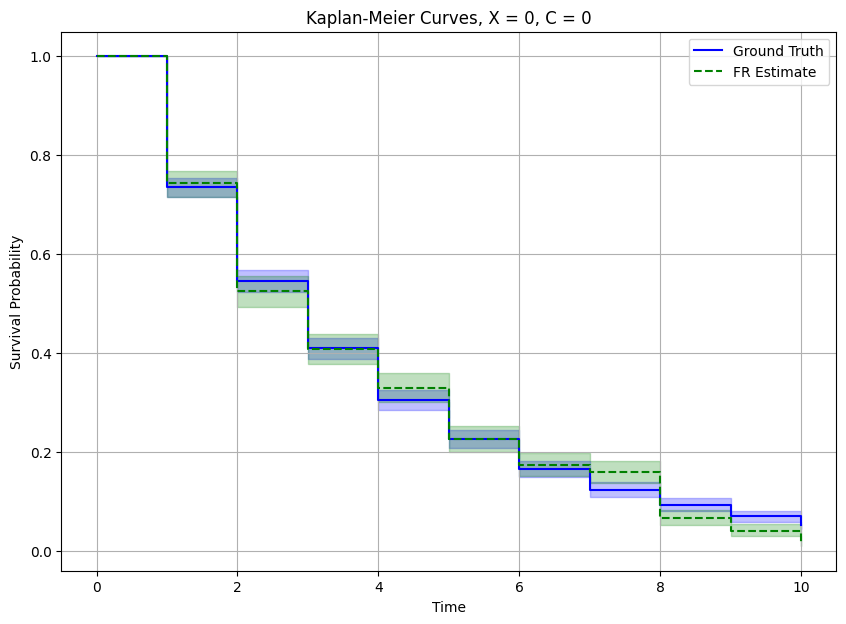

In [19]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

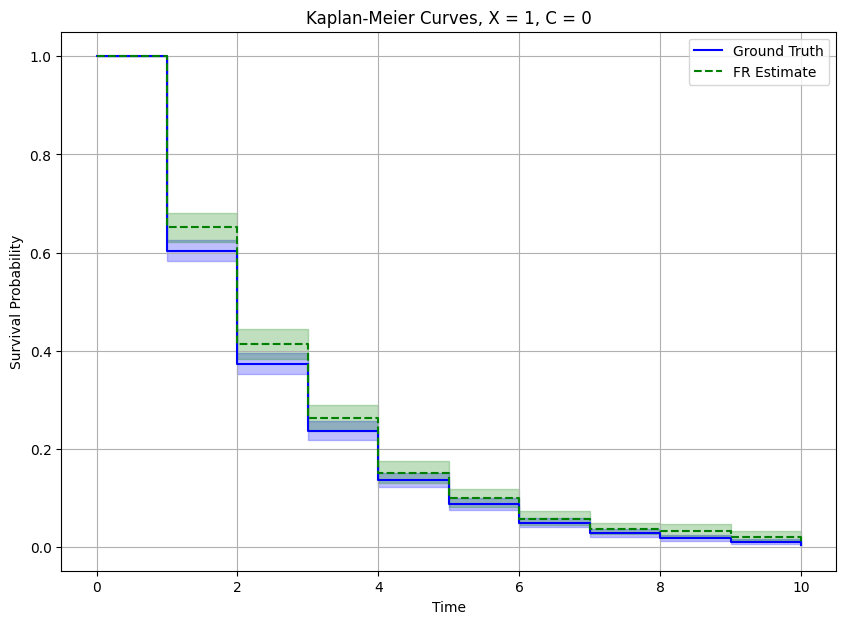

In [20]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [21]:

# torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

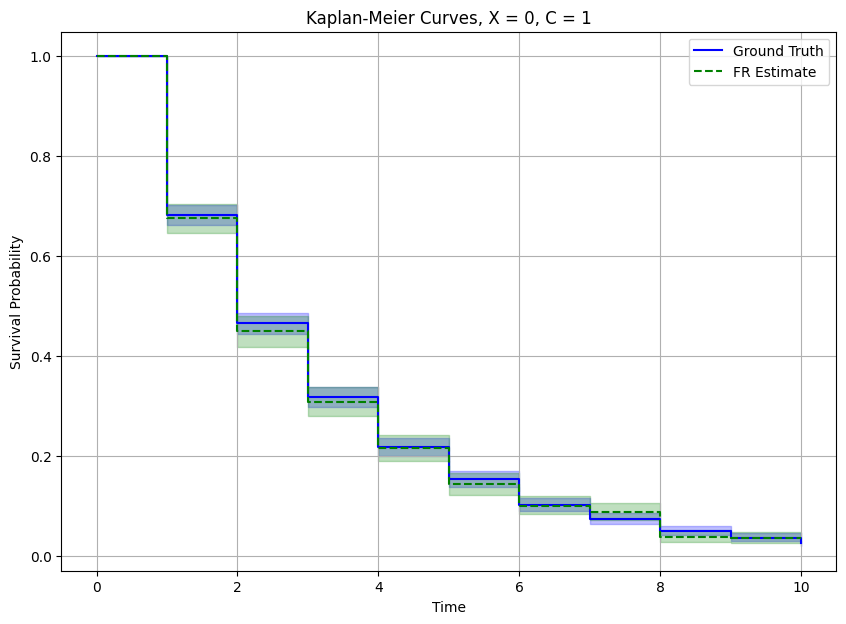

In [22]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

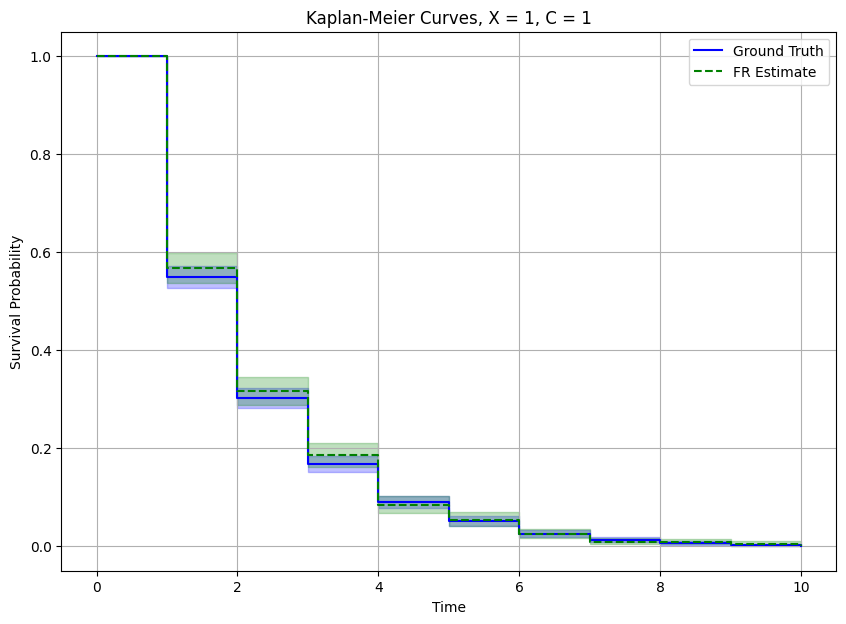

In [23]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

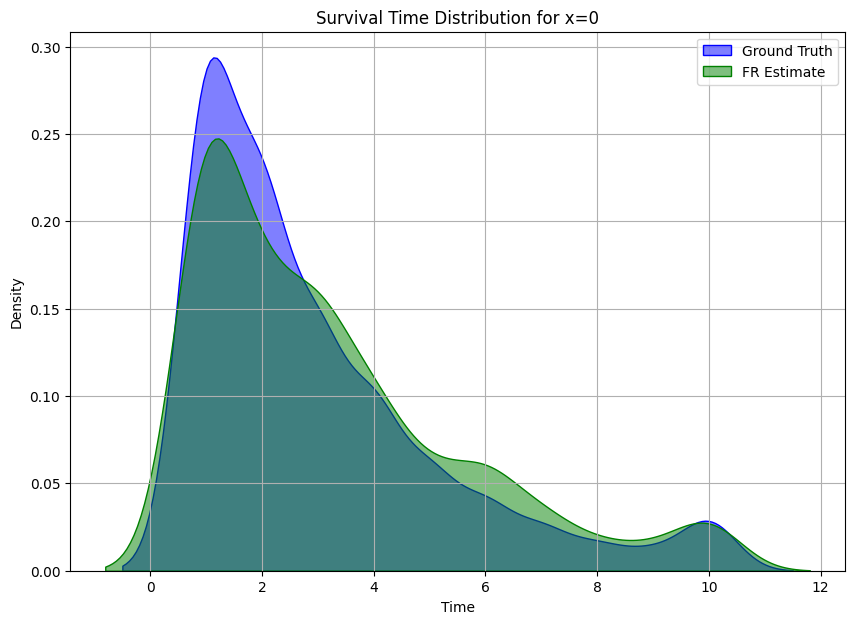

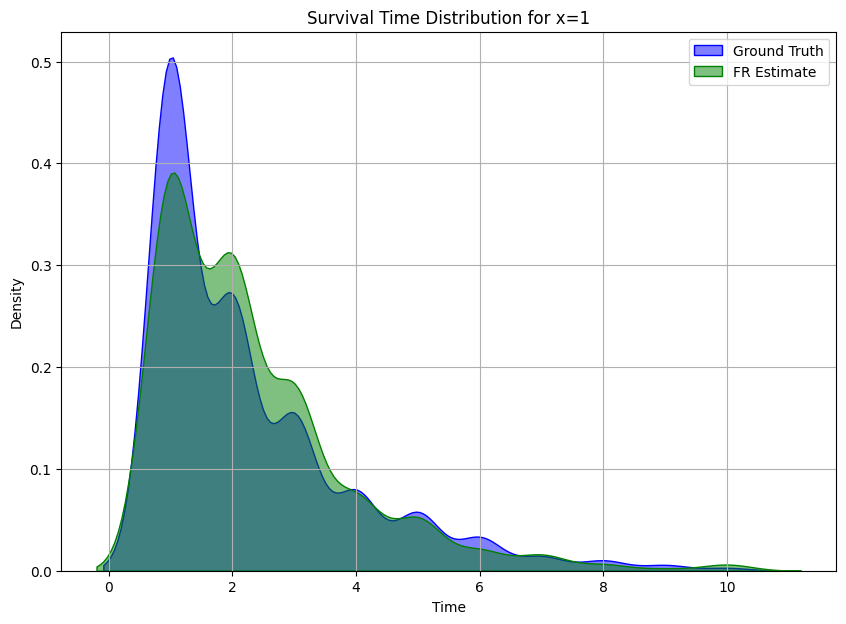

In [14]:
# Distribution for x=0
plot_survival_time_distribution(df_ground_truth=df_binary_x0,
                                df_estimate=df_x0,
                                x_value=0)

# Distribution for x=1
plot_survival_time_distribution(df_ground_truth=df_binary_x1,
                                df_estimate=df_x1,
                                x_value=1)


# Setting 2

In [49]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=2025, C_coeff=0.2, setting = 2)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1200, lr=1e-4, print_every_iter=500)

Epoch 1: loss 4.5041,	loss_y 1.5641, 1.5804, 0.0325,	loss_eta 2.9400, 3.1169, 0.3537
Epoch 500: loss 3.0819,	loss_y 0.9218, 1.5782, 1.3128,	loss_eta 2.1601, 4.3681, 4.4160
Epoch 1000: loss 2.9610,	loss_y 0.7969, 1.4525, 1.3112,	loss_eta 2.1641, 4.3440, 4.3598


In [50]:

C=0

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 1000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

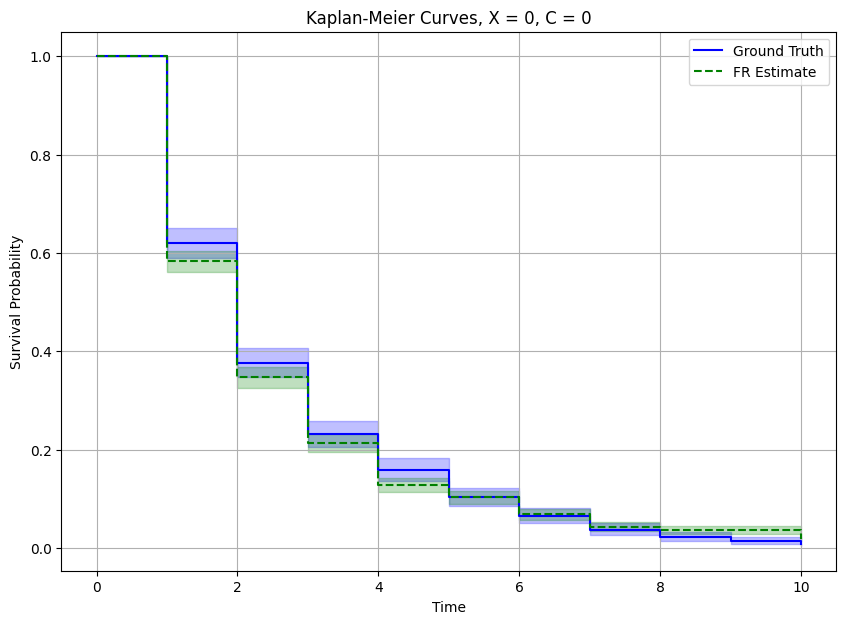

In [51]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

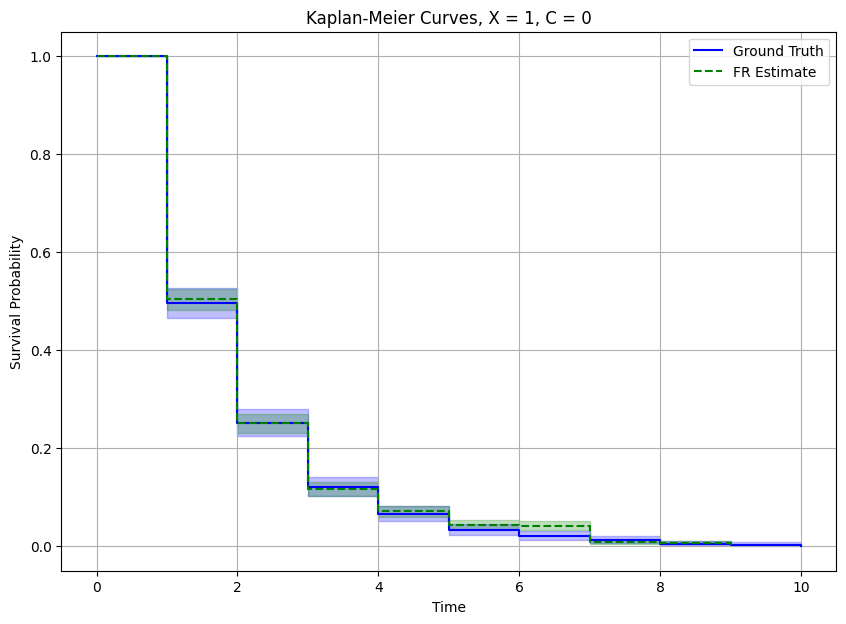

In [52]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [53]:

torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

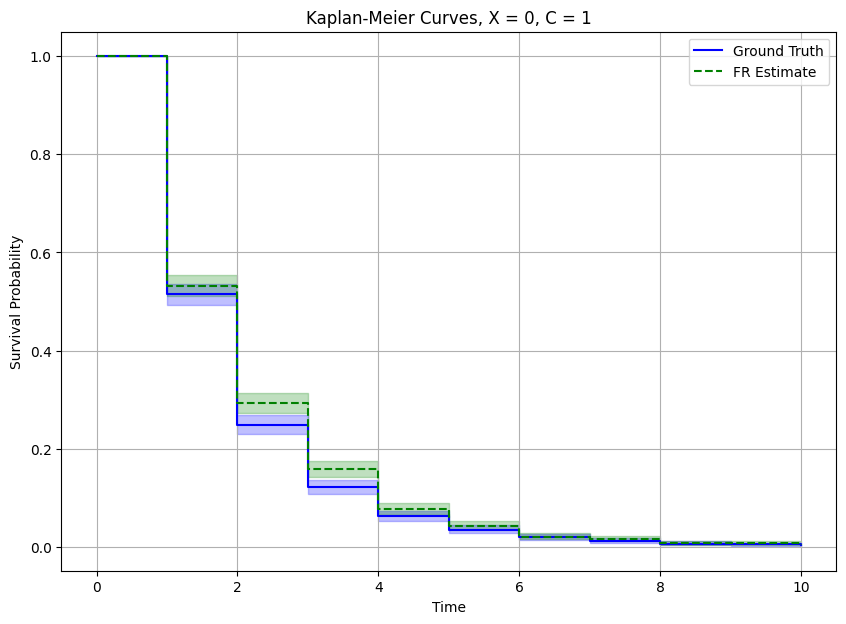

In [54]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

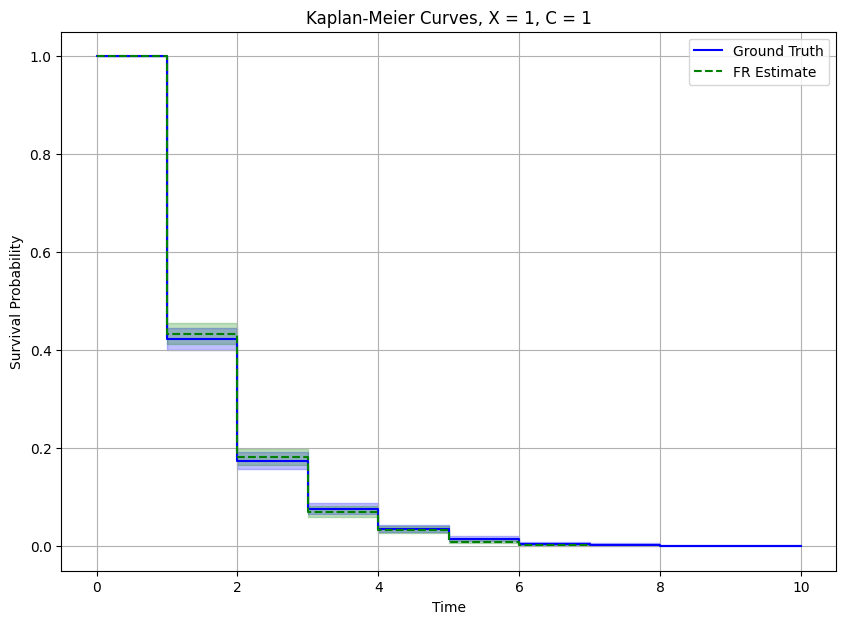

In [55]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 3

In [29]:
s,x,z,y = generate_data_survivl(n=5000,T=12, random_seed=2025, C_coeff=0.1, setting=3)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=12, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1400, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.9786,	loss_y 1.7211, 1.7380, 0.0337,	loss_eta 3.2575, 3.3859, 0.2568
Epoch 200: loss 3.6172,	loss_y 1.2009, 1.4347, 0.4676,	loss_eta 2.4163, 4.4472, 4.0618
Epoch 400: loss 3.4703,	loss_y 1.0704, 1.4997, 0.8586,	loss_eta 2.3999, 4.8193, 4.8388
Epoch 600: loss 3.3920,	loss_y 0.9843, 1.5746, 1.1807,	loss_eta 2.4077, 4.8208, 4.8262
Epoch 800: loss 3.3581,	loss_y 0.9525, 1.6252, 1.3454,	loss_eta 2.4056, 4.7982, 4.7852
Epoch 1000: loss 3.3214,	loss_y 0.9217, 1.6384, 1.4333,	loss_eta 2.3996, 4.7937, 4.7881
Epoch 1200: loss 3.2857,	loss_y 0.8897, 1.6201, 1.4608,	loss_eta 2.3960, 4.7824, 4.7728
Epoch 1400: loss 3.2375,	loss_y 0.8595, 1.5837, 1.4483,	loss_eta 2.3780, 4.7620, 4.7680


In [30]:
#torch.manual_seed(42)
C=0

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

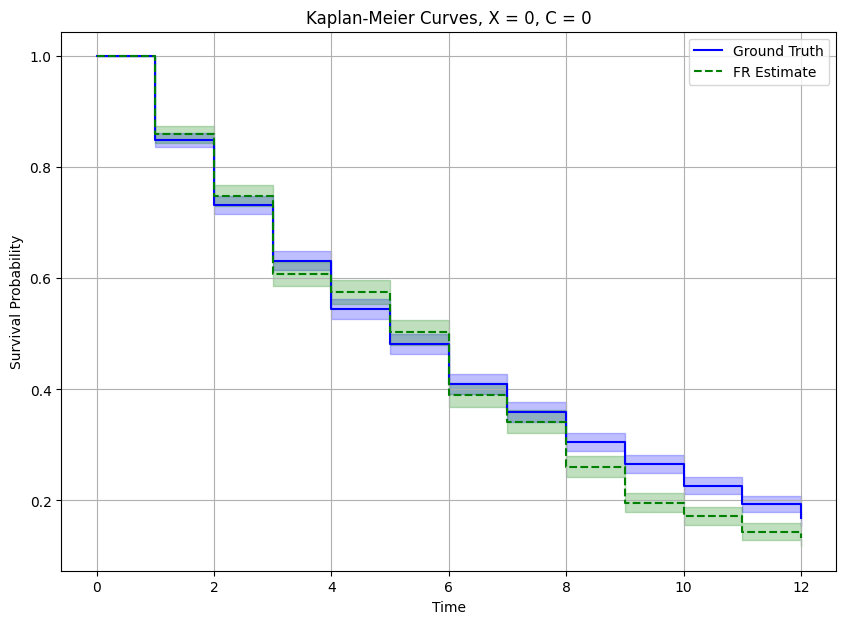

In [31]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

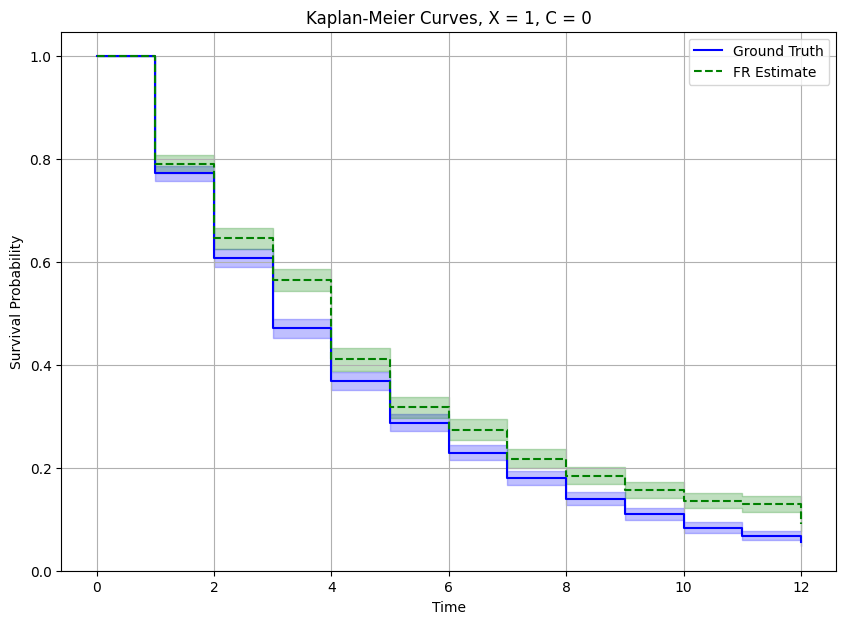

In [32]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [33]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

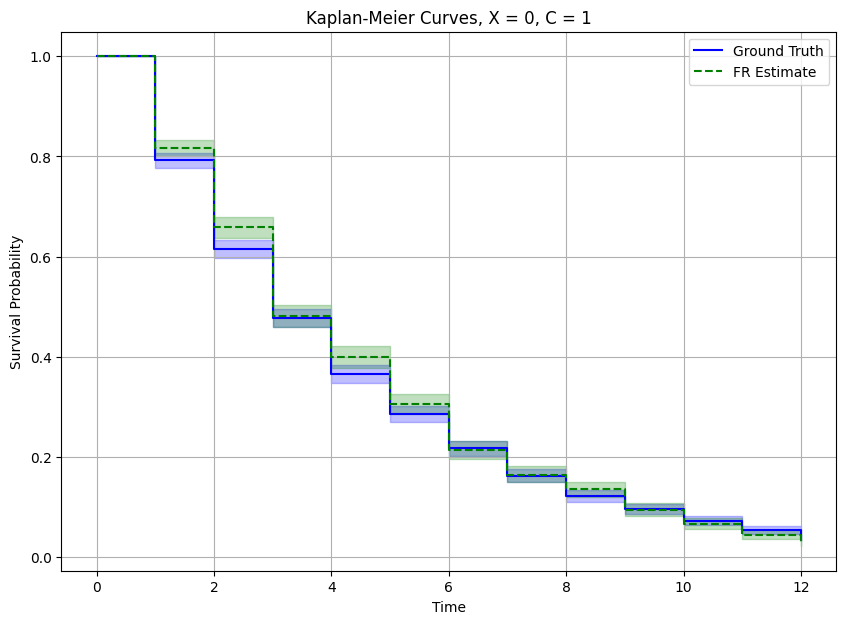

In [34]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

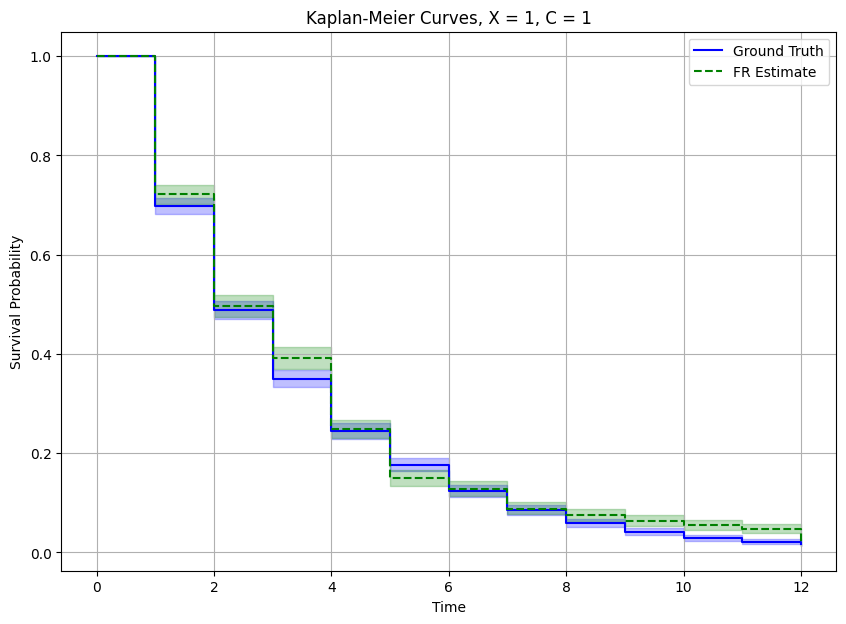

In [35]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 4

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=2025, C_coeff=0.1, setting=4)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.5445,	loss_y 1.5721, 1.5862, 0.0282,	loss_eta 2.9724, 3.1397, 0.3345
Epoch 200: loss 3.3757,	loss_y 1.1810, 1.5856, 0.8092,	loss_eta 2.1947, 4.1408, 3.8920
Epoch 400: loss 3.2423,	loss_y 1.0508, 1.7078, 1.3139,	loss_eta 2.1914, 4.3760, 4.3691
Epoch 600: loss 3.1905,	loss_y 0.9892, 1.7312, 1.4841,	loss_eta 2.2013, 4.3890, 4.3754
Epoch 800: loss 3.1013,	loss_y 0.9245, 1.6788, 1.5087,	loss_eta 2.1768, 4.3504, 4.3471
Epoch 1000: loss 3.0556,	loss_y 0.8621, 1.6022, 1.4801,	loss_eta 2.1934, 4.3576, 4.3283
Epoch 1200: loss 3.0061,	loss_y 0.8247, 1.5429, 1.4365,	loss_eta 2.1814, 4.3291, 4.2953
Epoch 1400: loss 2.9426,	loss_y 0.7735, 1.4497, 1.3524,	loss_eta 2.1691, 4.3250, 4.3119
Epoch 1600: loss 2.9008,	loss_y 0.7271, 1.3731, 1.2920,	loss_eta 2.1738, 4.3322, 4.3170
Epoch 1800: loss 2.8693,	loss_y 0.6954, 1.3189, 1.2469,	loss_eta 2.1738, 4.3391, 4.3305
Epoch 2000: loss 2.8583,	loss_y 0.6858, 1.3025, 1.2334,	loss_eta 2.1725, 4.3279, 4.3108


In [24]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 2.8076,	loss_y 0.6245, 1.1972, 1.1456,	loss_eta 2.1831, 4.3596, 4.3529
Epoch 200: loss 2.8004,	loss_y 0.6109, 1.1789, 1.1361,	loss_eta 2.1895, 4.3547, 4.3303
Epoch 400: loss 2.7673,	loss_y 0.5989, 1.1705, 1.1433,	loss_eta 2.1685, 4.3485, 4.3602
Epoch 600: loss 2.7636,	loss_y 0.5973, 1.1637, 1.1328,	loss_eta 2.1662, 4.3444, 4.3564
Epoch 800: loss 2.7754,	loss_y 0.6052, 1.1593, 1.1082,	loss_eta 2.1702, 4.3368, 4.3331
Epoch 1000: loss 2.7503,	loss_y 0.5784, 1.1272, 1.0976,	loss_eta 2.1719, 4.3612, 4.3784


In [31]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[2]*10],dtype=torch.float32),sample_size=2000))
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.7+0.1*C  # mean parameter
mu_x1 = 0.4+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

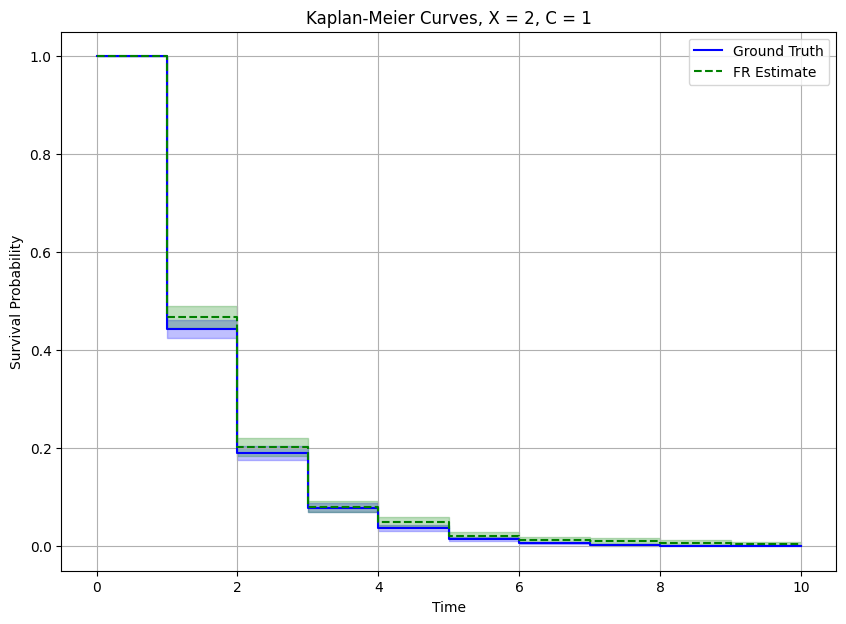

In [32]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 2, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

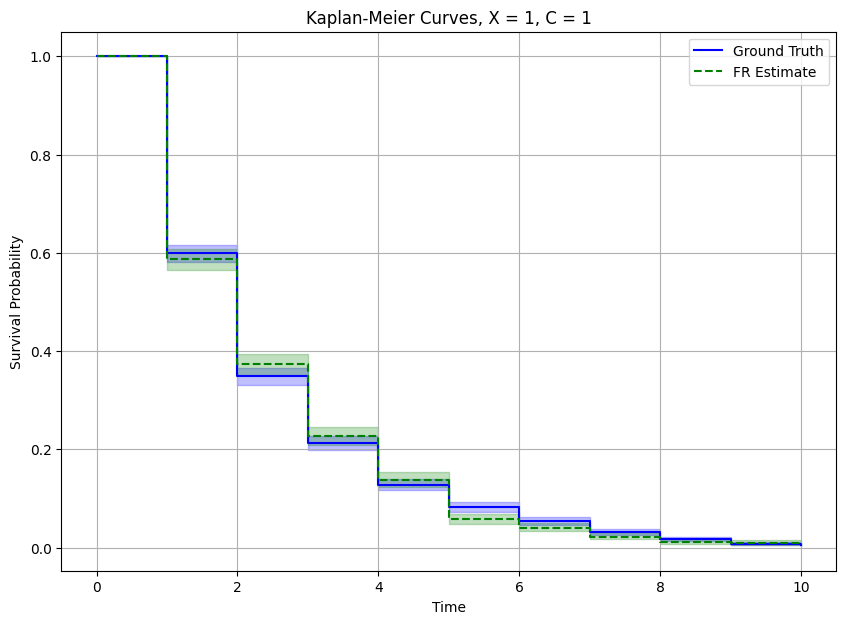

In [30]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()